# One Queue or Two

This notebook presents a case study from *Modeling and Simulation in Python*.  It explores a question related to queueing theory, which is the study of systems that involve waiting in lines, also known as "queues".

Suppose you are designing the checkout area for a new store.  There is room for two checkout counters and a waiting area for customers.  You can make two lines, one for each counter, or one line that serves both counters.

In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you would have to install rope barriers, and customers might be put off by what seems to be a longer line, even if it moves faster.

So you'd like to check whether the single line is really better and by how much.  Simulation can help answer this question.

As we did in the bikeshare model, we'll assume that a customer is equally likely to arrive during any timestep.  I'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`.  The value of $\lambda$ probably varies from day to day, so we'll have to consider a range of possibilities.

Based on data from other stores, you know that it takes 5 minutes for a customer to check out, on average.  But checkout times are highly variable: most customers take less than 5 minutes, but some take substantially more.  A simple way to model this variability is to assume that when a customer is checking out, they have the same probability of finishing up during each time step.  I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.

If we choose $\mu=1/5$, the average number of time steps for each checkout will be 5 minutes, which is consistent with the data.

## One server, one queue

Write a function called `make_system` that takes `lam` and `mu` as parameters and returns a `System` object with variables `lam`, `mu`, and `duration`.  Set `duration`, which is the number of time steps to simulate, to 10 hours, expressed in minutes. 

In [4]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/modsim.py')

In [5]:
from modsim import *

In [6]:
# Solution goes here
def make_system(lam, mu):
    return System(lam=lam,
                  mu=mu,
                  duration=600)

Test this function by creating a `System` object with `lam=1/8` and `mu=1/5`.

In [7]:
# Solution goes here
system1 = make_system(1/8, 1/5)
show(system1)

,value
lam,0.125
mu,0.200
duration,600.000


Write an update function that takes as parameters `x`, which is the total number of customers in the store, including the one checking out; `t`, which is the number of minutes that have elapsed in the simulation, and `system`, which is a `System` object.

If there's a customer checking out, it should use `flip` to decide whether they are done.  And it should use `flip` to decide if a new customer has arrived.

It should return the total number of customers at the end of the time step.

In [29]:
# Solution goes here
def update_func1(x, t, system):
    lam, mu = system.lam, system.mu
    if flip(lam):
        x += 1
    if flip(mu):
        # add a check to make sure x does not go negative
        if x > 0:
            x -= 1
        #x -= 1
    return x

Test your function by calling it with `x=1`, `t=0`, and the `System` object you created.  If you run it a few times, you should see different results.

In [30]:
# Solution goes here
test = update_func1(1, 0, system1)
print(test)

1


Now we can run the simulation.  Here's a version of `run_simulation` that creates a `TimeSeries` with the total number of customers in the store, including the one checking out.

In [31]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x = 0
    results = TimeSeries(name='Queue length')
    results[0] = x
    
    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x

    return results

Call `run_simulation` with your update function and plot the results.

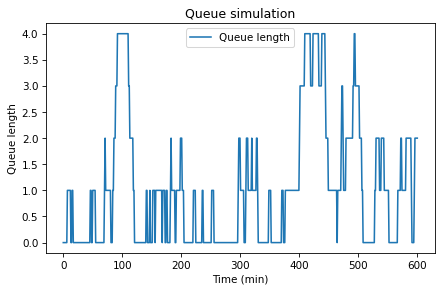

In [32]:
# Solution goes here
results = run_simulation(system1, update_func1)
results.plot()
decorate(title='Queue simulation',
         xlabel='Time (min)',
         ylabel='Queue length')

After the simulation, we can compute `L`, which is the average number of customers in the system, and `W`, which is the average time customers spend in the store.  `L` and `W` are related by Little's Law:

$L = \lambda W$

Where $\lambda$ is the arrival rate.  Here's a function that computes them.

In [19]:
def compute_metrics(results, system):
    """Compute average number of customers and wait time.
    
    results: TimeSeries of queue lengths
    system: System object
    
    returns: L, W
    """
    L = results.mean()
    W = L / system.lam
    return L, W

Call `compute_metrics` with the results from your simulation.

In [33]:
# Solution goes here
L, W = compute_metrics(results, system1)
L, W

(1.0348837209302326, 8.279069767441861)

### Parameter sweep

Since we don't know the actual value of $\lambda$, we can sweep through a range of possibilities, from 10% to 80% of the completion rate, $\mu$.  (If customers arrive faster than the completion rate, the queue grows without bound.  In that case the metrics `L` and `W` just depend on how long the store is open.)

Create an array of values for `lam`.

In [67]:
# Solution goes here
mu = 1/5
array_lam = linspace(0.1*mu, .8*mu, 10)

Write a function that takes an array of values for `lam`, a single value for `mu`, and an update function.

For each value of `lam`, it should run a simulation, compute `L` and `W`, and store the value of `W` in a `SweepSeries`.

It should return the `SweepSeries`.

In [35]:
# Solution goes here
def sweep_lam(array_lam, mu, update_func):
    sweep = SweepSeries()
    for lam in array_lam:
        system = make_system(lam, mu)
        results = run_simulation(system, update_func)
        L, W = compute_metrics(results, system)
        sweep[lam] = W

    return sweep

Call your function to generate a `SweepSeries`, and plot it.

In [82]:
# Solution goes here
sweep = sweep_lam(array_lam, 1/5, update_func1)

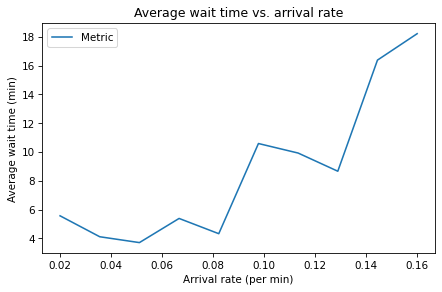

In [83]:
# Solution goes here
sweep.plot()
decorate(title='Average wait time vs. arrival rate',
         xlabel='Arrival rate (per min)',
         ylabel='Average wait time (min)')

If we imagine that this range of values represents arrival rates on different days, we can use the average value of `W`, for a range of values of `lam`, to compare different queueing strategies.

In [106]:
# Solution goes here
sweep.mean()

8.684055223933026

### Analysis

The model I chose for this system is a common model in queueing theory, in part because many of its properties can be derived analytically.

In particular, we can derive the average time in the store as a function of $\mu$ and $\lambda$:

$W = 1 / (\mu - \lambda)$

The following function plots the theoretical value of $W$ as a function of $\lambda$.

In [76]:
def plot_W(lam_array, mu):
    """Plot the theoretical mean wait time.
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    """
    W_array = 1 / (mu - lam_array)
    W_series = make_series(lam_array, W_array)
    W_series.plot(style='-', label='analysis')

Use this function to plot the theoretical results, then plot your simulation results again on the same graph.  How do they compare?

<Axes: xlabel='Parameter'>

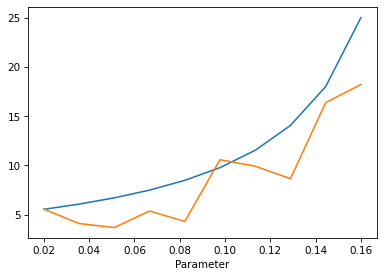

In [84]:
# Solution goes here
plot_W(array_lam, 1/5)
sweep.plot(label='simulation')

The two plotted lines both follow an overall upward and similar trend. However, the mathematically derived model is a much smoother line due to a lack of random fluctuations due to regular noise found in real life events. The simulated line has a lot of wild fluctuations that more closely mimic real-life scenarios. This visible difference is expected to shrink and be less noticeable with larger durations in the simulation, again, similar to real-life cases.

## Multiple servers

Now let's try the other two queueing strategies:

1.  One queue with two checkout counters.
2.  Two queues, one for each counter.

The following figure shows the three scenarios:

![](https://github.com/AllenDowney/ModSim/raw/main/figs/queue.png)

Write an update function for one queue with two servers.

In [86]:
# Solution goes here
def update_func2(x, t, system):
    lam, mu = system.lam, system.mu
    if flip(lam):
        x += 1
    if flip(mu):
        if x > 0:
            x -= 1
    # add a second checkout line
    if flip(mu):
        if x > 0:
            x -= 1
    return x

Use this update function to simulate the system, plot the results, and print the metrics.

(0.446843853820598, 3.574750830564784)

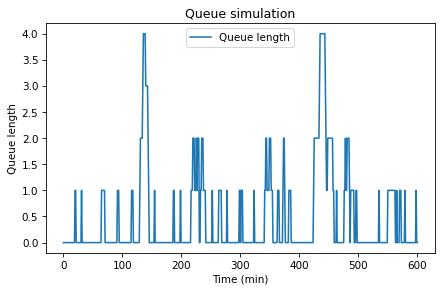

In [90]:
# Solution goes here
system2 = make_system(1/8, 1/5)
results = run_simulation(system2, update_func2)
results.plot()
decorate(title='Queue simulation',
         xlabel='Time (min)',
         ylabel='Queue length')

L, W = compute_metrics(results, system2)
L, W

*The average length of the queue in this simulation was 0.45 customers and the average wait time per customer was 3.57 minutes.*

Since we have two checkout counters now, we can consider values for $\lambda$ that exceed $\mu$.

Create a new array of values for `lam` from 10% to 160% of `mu`.

In [91]:
# Solution goes here
array_lam2 = linspace(0.1*mu, 1.6*mu, 10)

Use your sweep function to simulate the two server, one queue scenario with a range of values for `lam`.

Plot the results and print the average value of `W` across all values of `lam`.

In [205]:
# Solution goes here
sweep2 = sweep_lam(array_lam2, 1/5, update_func2)

3.0278199497930376

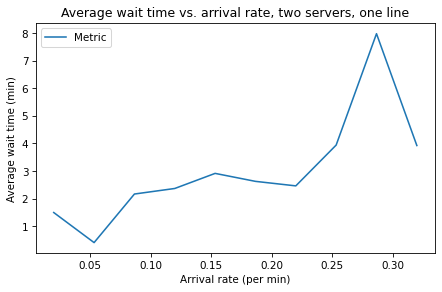

In [206]:
# Solution goes here
sweep2.plot()
decorate(title='Average wait time vs. arrival rate, two servers, one line',
         xlabel='Arrival rate (per min)',
         ylabel='Average wait time (min)')

sweep2.mean()

*The average wait time accross all the values of lambda simulated is 3.05 minutes. This is significantly less than the averaqge with only one server and line.*

## Multiple queues

To simulate the scenario with two separate queues, we need two state variables to keep track of customers in each queue.

Write an update function that takes `x1`, `x2`, `t`, and `system` as parameters and returns `x1` and `x2` as return values.  f you are not sure how to return more than one return value, see `compute_metrics`.

When a customer arrives, which queue do they join?

In [107]:
# Solution goes here
def update_func3(x1, x2, t, system):
    lam, mu = system.lam, system.mu
    if flip(lam):
        if x1 < x2:
            x1 += 1
        elif x2 < x1:
            x2 += 1
        else:
            if flip():
                x1 += 1
            else:
                x2 += 1
    if flip(mu):
        if x1 > 0:
            x1 -= 1
        #elif x2 > 0:
        #    x2 -= 1
    if flip(mu):
        if x2 > 0:
            x2 -= 1
        #elif x1 > 0:
        #    x1 -= 1
    return x1, x2

*For this function, I kept the two states completely separate and did not allow customers to switch lines in middle. In real life, customers can switch. While that makes it much harder to simulate, we can assume that if one line completely finishes, a customer from the other line will switch over. To allow for this scenario, simply remove the commented lines in the above function*

Write a version of `run_simulation` that works with this update function.

In [111]:
# Solution goes here
def run_simulation2(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x1 = 0
    x2 = 0
    results = TimeFrame(columns=['x1', 'x2'])
    results.loc[0] = x1, x2

    for t in linrange(0, system.duration):
        x1, x2 = update_func(x1, x2, t, system)
        results.loc[t+1] = x1, x2

    return results

Test your functions by running a simulation with a single value of `lam`.

<Axes: >

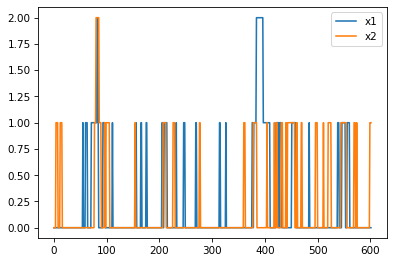

In [207]:
# Solution goes here
system3 = make_system(1/8, 1/5)
results = run_simulation2(system3, update_func3)
results.plot()

Sweep a range of values for `lam`, plot the results, and print the average wait time across all values of `lam`.

How do the results compare to the scenario with two servers and one queue.

In [145]:
# Solution goes here
array_lam3 = linspace(0.1*mu, 1.6*mu, 10)

In [218]:
# Solution goes here
def sweep_lam2(array_lam, mu, update_func):
    sweep = SweepSeries()
    for lam in array_lam:
        system = make_system(lam, mu)
        results = run_simulation2(system, update_func)
        L1 = results.x1.mean()
        L2 = results.x2.mean()
        W1 = L1 / system.lam
        W2 = L2 / system.lam
        W = (W1 + W2) / 2
        sweep[lam] = W

    return sweep

2.8850854030390147

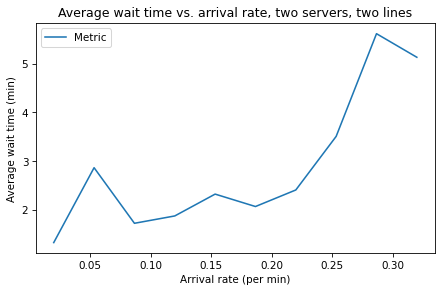

In [221]:
# Solution goes here
sweep3 = sweep_lam2(array_lam3, 1/5, update_func3)

sweep3.plot()
decorate(title='Average wait time vs. arrival rate, two servers, two lines',
         xlabel='Arrival rate (per min)',
         ylabel='Average wait time (min)')

sweep3.mean()

*The average wait time teems to be significantly shorter when using two separate lines for the two registers. This is very surprising to me and makes me wonder if I did anything wrong here, particularly in computing the metrics.*

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)